In [1]:
# Delphi PID exploration!  Here we aim to study reco PID performance

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import ROOT

uproot.default_library = "np"

Welcome to JupyROOT 6.26/06


ldd: exited with unknown exit code (139)


In [3]:
file = uproot.open("nanoaod_kk2f4146_qqpy_91.25_40262.sdst_ttree.root")
tree = file["t"]

In [4]:
tree.keys()

['Btag_probAllIP',
 'Btag_probNegIP',
 'Btag_probPosIP',
 'Btag_thrustVector',
 'Btag_thrustVector/fCoordinates',
 'Btag_thrustVector/fCoordinates/fCoordinates.fX',
 'Btag_thrustVector/fCoordinates/fCoordinates.fY',
 'Btag_thrustVector/fCoordinates/fCoordinates.fZ',
 'Btag_thrustVector_fCoordinates',
 'Btag_thrustVector_fCoordinates/fX',
 'Btag_thrustVector_fCoordinates/fY',
 'Btag_thrustVector_fCoordinates/fZ',
 'Btag_thrustVector_fCoordinates_fX',
 'Btag_thrustVector_fCoordinates_fY',
 'Btag_thrustVector_fCoordinates_fZ',
 'Dedx_error',
 'Dedx_gapWires',
 'Dedx_nrVDHits',
 'Dedx_nrWires',
 'Dedx_value',
 'Dedx_valueVD',
 'Dedx_width',
 'Elid_gammaConversion',
 'Elid_partIdx',
 'Elid_px',
 'Elid_py',
 'Elid_pz',
 'Elid_tag',
 'Event_DSTType',
 'Event_chargedMult',
 'Event_chargedMultT4',
 'Event_cmEnergy',
 'Event_date',
 'Event_evtNumber',
 'Event_fillNumber',
 'Event_hadronTagT4',
 'Event_magField',
 'Event_neutralMult',
 'Event_runNumber',
 'Event_time',
 'Event_totalChargedEnergy'

In [5]:
# Some helper functions

In [6]:
def Magnitude(px, py, pz):
    return np.sqrt(px * px + py * py + pz * pz)

def DotProduct(px1, py1, pz1, px2, py2, pz2):
    return px1 * px2 + py1 * py2 + pz1 * pz2

def CosAngle(px1, py1, pz1, px2, py2, pz2):
    return DotProduct(px1, py1, pz1, px2, py2, pz2) / Magnitude(px1, py1, pz1) / Magnitude(px2, py2, pz2)

def GetAngle(px1, py1, pz1, px2, py2, pz2):
    Value = CosAngle(px1, py1, pz1, px2, py2, pz2)
    if Value < -1:
        Value = -1
    if Value > 1:
        Value = 1
    return np.arccos(Value)

In [7]:
# Now we massage things so that it is simpler to navigate.  We focus on one particle type to start with

In [33]:
GenAlias           = {}
GenAlias["px"]     = "GenPart_vector/GenPart_vector.fCoordinates.fX"
GenAlias["py"]     = "GenPart_vector/GenPart_vector.fCoordinates.fY"
GenAlias["pz"]     = "GenPart_vector/GenPart_vector.fCoordinates.fZ"
GenAlias["E"]      = "GenPart_vector/GenPart_vector.fCoordinates.fT"
GenAlias["mass"]   = "GenPart_mass"
GenAlias["id"]     = "GenPart_pdgId"
GenAlias["status"] = "GenPart_status"

PionSelection = "(status == 1) & ((id == 211) | (id == -211))"
KaonSelection = "(status == 1) & ((id == 321) | (id == -321))"

GenPion = tree.arrays(["px", "py", "pz", "E", "mass", "id", "status"], PionSelection, aliases = GenAlias)
GenKaon = tree.arrays(["px", "py", "pz", "E", "mass", "id", "status"], KaonSelection, aliases = GenAlias)

RecoAlias           = {}
RecoAlias["px"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fX"
RecoAlias["py"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fY"
RecoAlias["pz"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fZ"
RecoAlias["E"]      = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fT"
RecoAlias["charge"] = "Part_charge"
RecoAlias["id"]     = "Part_pdgId"

Reco = tree.arrays(["px", "py", "pz", "E", "charge", "id"], "charge != 0", aliases = RecoAlias)

PIDAlias = {}
PIDAlias["dedx"]        = "Dedx_valueVD"
PIDAlias["ElectronTag"] = 'Haidc_electronTag'
PIDAlias["HeavyTag"]    = 'Haidc_heavyTag'
PIDAlias["KaonTag"]     = 'Haidc_kaonTag'
PIDAlias["PionTag"]     = 'Haidc_pionTag'
PIDAlias["ProtonTag"]   = 'Haidc_protonTag'
PIDAlias["Selection"]   = 'Haidc_selectionFlag'

PID = tree.arrays(["dedx", "ElectronTag", "HeavyTag", "PionTag", "ProtonTag", "Selection"], aliases = PIDAlias)

In [34]:
print('dedx branch sizes', len(tree["Dedx_valueVD"].array()[0]))
print('reco particle count', len(tree["Part_pdgId"].array()[0]))
print('charged reco particle count', len(Reco["id"][0]))
print('rich detector sizes', len(tree["Rich_thel"].array()[0]))
print('hadron ID c sizes', len(tree['Haidc_heavyTag'].array()[0]))

dedx branch sizes 14
reco particle count 29
charged reco particle count 14
rich detector sizes 14
hadron ID c sizes 14


In [35]:
PID

<Array [{dedx: [...], ...}, {...}, ..., {...}] type='3000 * {dedx: var * fl...'>

In [11]:
np.array(GenPion[3].px)

array([ 2.1030915 ,  0.2057421 ,  0.587028  , -0.0636582 ,  0.02038759,
       -0.7546718 ,  0.40312383,  0.04469083,  0.49513212,  0.23774482,
        0.6351827 , -0.3976336 , -0.17403279,  0.14716908, -0.12312401,
       -0.6153422 , -3.3862057 ], dtype=float32)

In [12]:
print("pions", set.union(*map(set, GenPion.id)))
print("kaons", set.union(*map(set, GenKaon.id)))

pions {211, -211}
kaons {321, -321}


In [13]:
# Doing the simple-minded matching for now

In [14]:
GenPionMatch = []
GenPionAngle = []
GenKaonMatch = []
GenKaonAngle = []

for iE, entry in enumerate(GenPion):
    NGen = len(GenPion[iE].px)
    NReco = len(Reco[iE].px)

    # Temporarily copy things out of awkward array to make it run faster
    GenPx = np.array(GenPion[iE].px)
    GenPy = np.array(GenPion[iE].py)
    GenPz = np.array(GenPion[iE].pz)
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    MatchingIndex = np.full(NGen, -1.0)
    MatchingAngle = np.full(NGen, -1.0)
    for iG in range(NGen):
        BestIndex = -1
        BestDistance = -1
        for iR in range(NReco):
            Distance = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], RecoPx[iR], RecoPy[iR], RecoPz[iR])

            if BestIndex < 0 or BestDistance > Distance:
                BestIndex = iR
                BestDistance = Distance
            # print(Distance, BestDistance)
            # print(GenPx[iG], GenPy[iG], GenPz[iG], RecoPx[iR], RecoPy[iR], RecoPz[iR])

        MatchingIndex[iG] = BestIndex
        MatchingAngle[iG] = BestDistance

    GenPionMatch.append(MatchingIndex)
    GenPionAngle.append(MatchingAngle)


for iE, entry in enumerate(GenKaon):
    NGen = len(GenKaon[iE].px)
    NReco = len(Reco[iE].px)

    # Temporarily copy things out of awkward array to make it run faster
    GenPx = np.array(GenKaon[iE].px)
    GenPy = np.array(GenKaon[iE].py)
    GenPz = np.array(GenKaon[iE].pz)
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    MatchingIndex = np.full(NGen, -1.0)
    MatchingAngle = np.full(NGen, -1.0)
    for iG in range(NGen):
        BestIndex = -1
        BestDistance = -1
        for iR in range(NReco):
            Distance = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], RecoPx[iR], RecoPy[iR], RecoPz[iR])

            if BestIndex < 0 or BestDistance > Distance:
                BestIndex = iR
                BestDistance = Distance
            # print(Distance, BestDistance)
            # print(GenPx[iG], GenPy[iG], GenPz[iG], RecoPx[iR], RecoPy[iR], RecoPz[iR])

        MatchingIndex[iG] = BestIndex
        MatchingAngle[iG] = BestDistance

    GenKaonMatch.append(MatchingIndex)
    GenKaonAngle.append(MatchingAngle)

In [15]:
GenPionAngle

[array([1.98340812e-03, 2.88871187e-03, 1.89110544e-03, 1.89110544e-03,
        4.59595844e-02, 7.26020813e-01, 2.74047256e-03, 3.45266977e-04,
        1.33721333e-03, 9.76562500e-04]),
 array([0.00084573, 0.01636307, 0.00048828, 0.00119604, 0.00069053,
        0.00034527, 0.09886143, 0.00084573, 0.00967984, 0.00325724,
        0.0038136 , 0.01069776, 0.00274047, 0.        , 0.        ,
        0.00572561, 0.00598021, 0.        ]),
 array([0.00034527, 0.00212837, 0.09945749, 0.26945388, 0.00541531,
        0.09328084, 0.00253718, 0.00169146, 0.00637577, 0.0074613 ,
        0.00346989, 0.01064189]),
 array([0.00367024, 0.24246727, 0.00244141, 0.        , 0.00294996,
        0.00091349, 0.00422864, 0.01041544, 0.01085814, 0.00604958,
        0.00524761, 0.00803815, 0.27112854, 0.0069226 , 0.08406021,
        0.00239208, 0.        ]),
 array([0.00000000e+00, 3.45266977e-04, 3.78221250e-03, 1.11185117e-02,
        0.00000000e+00, 3.27549176e-03, 5.98019978e-04, 1.42357231e-03,
        1.18

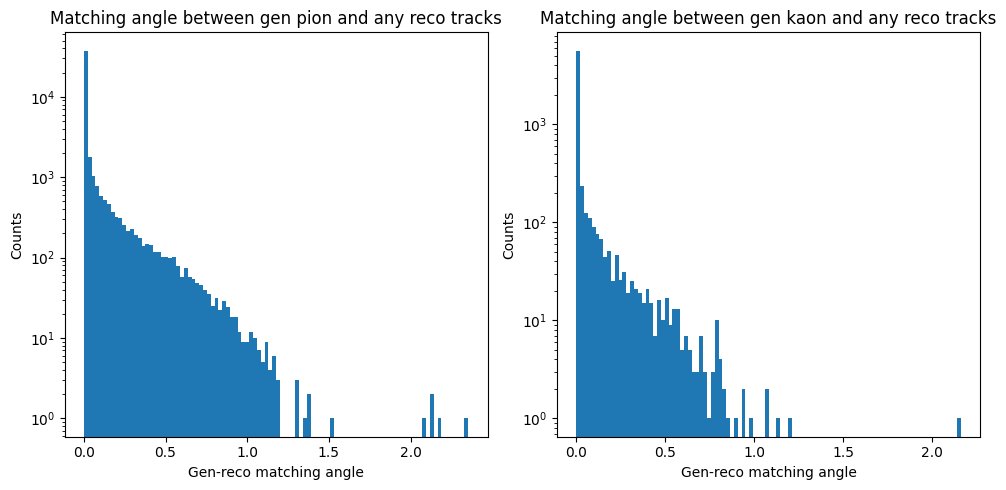

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].set_title('Matching angle between gen pion and any reco tracks')
axes[0].hist(np.concatenate(GenPionAngle), bins=100)
axes[0].set_xlabel('Gen-reco matching angle')
axes[0].set_ylabel('Counts')
axes[0].set_yscale('log')

axes[1].set_title('Matching angle between gen kaon and any reco tracks')
axes[1].hist(np.concatenate(GenKaonAngle), bins=100)
axes[1].set_xlabel('Gen-reco matching angle')
axes[1].set_ylabel('Counts')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

In [ ]:
# Now we make efficiency plots

In [19]:
HPionPTPass    = ROOT.TH1D("HPionPTPass", "No theta selection;Gen PT;Counts", 100, 0, 15)
HPionPTAll     = ROOT.TH1D("HPionPTAll", "No theta selection;Gen PT;Counts", 100, 0, 15)
HPionThetaPass = ROOT.TH1D("HPionThetaPass", "PT > 0.4;Gen Theta;Counts", 100, 0, np.pi)
HPionThetaAll  = ROOT.TH1D("HPionThetaAll", "PT > 0.4;Gen Theta;Counts", 100, 0, np.pi)
HPionPTInPass  = ROOT.TH1D("HPionPTInPass", "Theta = 20-160 degrees;Gen PT;Counts", 100, 0, 15)
HPionPTInAll   = ROOT.TH1D("HPionPTInAll", "Theta = 20-160 degrees;Gen PT;Counts", 100, 0, 15)
HPionPTBBPass  = ROOT.TH1D("HPionPTBBPass", "Theta = 45-135 degrees;Gen PT;Counts", 100, 0, 15)
HPionPTBBAll   = ROOT.TH1D("HPionPTBBAll", "Theta = 45-135 degrees;Gen PT;Counts", 100, 0, 15)
HKaonPTPass    = ROOT.TH1D("HKaonPTPass", "No theta selection;Gen PT;Counts", 100, 0, 15)
HKaonPTAll     = ROOT.TH1D("HKaonPTAll", "No theta selection;Gen PT;Counts", 100, 0, 15)
HKaonThetaPass = ROOT.TH1D("HKaonThetaPass", "PT > 0.4;Gen Theta;Counts", 100, 0, np.pi)
HKaonThetaAll  = ROOT.TH1D("HKaonThetaAll", "PT > 0.4;Gen Theta;Counts", 100, 0, np.pi)
HKaonPTInPass  = ROOT.TH1D("HKaonPTInPass", "Theta = 20-160 degrees;Gen PT;Counts", 100, 0, 15)
HKaonPTInAll   = ROOT.TH1D("HKaonPTInAll", "Theta = 20-160 degrees;Gen PT;Counts", 100, 0, 15)
HKaonPTBBPass  = ROOT.TH1D("HKaonPTBBPass", "Theta = 45-135 degrees;Gen PT;Counts", 100, 0, 15)
HKaonPTBBAll   = ROOT.TH1D("HKaonPTBBAll", "Theta = 45-135 degrees;Gen PT;Counts", 100, 0, 15)

for iE in range(len(GenPion)):
    # Again get stuff out of the awkwardness to speed things up
    GenPx = np.array(GenPion[iE].px)
    GenPy = np.array(GenPion[iE].py)
    GenPz = np.array(GenPion[iE].pz)
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    NGen = len(GenPx)

    for iG in range(NGen):

        GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
        GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)
        
        HPionPTAll.Fill(GenPT)
        if GenPT > 0.4:
            HPionThetaAll.Fill(GenTheta)
        if GenTheta > np.pi / 9 and GenTheta < 8 * np.pi / 9:
            HPionPTInAll.Fill(GenPT)
        if GenTheta > np.pi / 4 and GenTheta < 3 * np.pi / 4:
            HPionPTBBAll.Fill(GenPT)
        
        if GenPionAngle[iE][iG] < 0.01:
            HPionPTPass.Fill(GenPT)
            if GenPT > 0.4:
                HPionThetaPass.Fill(GenTheta)
            if GenTheta > np.pi / 9 and GenTheta < 8 * np.pi / 9:
                HPionPTInPass.Fill(GenPT)
            if GenTheta > np.pi / 4 and GenTheta < 3 * np.pi / 4:
                HPionPTBBPass.Fill(GenPT)

for iE in range(len(GenKaon)):
    # Again get stuff out of the awkwardness to speed things up
    GenPx = np.array(GenKaon[iE].px)
    GenPy = np.array(GenKaon[iE].py)
    GenPz = np.array(GenKaon[iE].pz)
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    NGen = len(GenPx)

    for iG in range(NGen):

        GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
        GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)
        
        HKaonPTAll.Fill(GenPT)
        if GenPT > 0.4:
            HKaonThetaAll.Fill(GenTheta)
        if GenTheta > np.pi / 9 and GenTheta < 8 * np.pi / 9:
            HKaonPTInAll.Fill(GenPT)
        if GenTheta > np.pi / 4 and GenTheta < 3 * np.pi / 4:
            HKaonPTBBAll.Fill(GenPT)
        
        if GenKaonAngle[iE][iG] < 0.01:
            HKaonPTPass.Fill(GenPT)
            if GenPT > 0.4:
                HKaonThetaPass.Fill(GenTheta)
            if GenTheta > np.pi / 9 and GenTheta < 8 * np.pi / 9:
                HKaonPTInPass.Fill(GenPT)
            if GenTheta > np.pi / 4 and GenTheta < 3 * np.pi / 4:
                HKaonPTBBPass.Fill(GenPT)

HPionPTEfficiency = ROOT.TGraphAsymmErrors()
HPionPTEfficiency.Divide(HPionPTPass, HPionPTAll)
HPionPTEfficiency.SetTitle("No theta selection")
HPionPTEfficiency.GetXaxis().SetTitle("Gen PT")
HPionPTEfficiency.GetYaxis().SetTitle("Efficiency")

HPionThetaEfficiency = ROOT.TGraphAsymmErrors()
HPionThetaEfficiency.Divide(HPionThetaPass, HPionThetaAll)
HPionThetaEfficiency.SetTitle("PT > 0.4")
HPionThetaEfficiency.GetXaxis().SetTitle("Gen Theta")
HPionThetaEfficiency.GetYaxis().SetTitle("Efficiency")

HPionPTInEfficiency = ROOT.TGraphAsymmErrors()
HPionPTInEfficiency.Divide(HPionPTInPass, HPionPTInAll)
HPionPTInEfficiency.SetTitle("Theta = 20 - 160 degrees")
HPionPTInEfficiency.GetXaxis().SetTitle("Gen PT")
HPionPTInEfficiency.GetYaxis().SetTitle("Efficiency")

HPionPTBBEfficiency = ROOT.TGraphAsymmErrors()
HPionPTBBEfficiency.Divide(HPionPTBBPass, HPionPTBBAll)
HPionPTBBEfficiency.SetTitle("Theta = 45 - 135 degrees")
HPionPTBBEfficiency.GetXaxis().SetTitle("Gen PT")
HPionPTBBEfficiency.GetYaxis().SetTitle("Efficiency")

HKaonPTEfficiency = ROOT.TGraphAsymmErrors()
HKaonPTEfficiency.Divide(HKaonPTPass, HKaonPTAll)
HKaonPTEfficiency.SetTitle("No theta selection")
HKaonPTEfficiency.GetXaxis().SetTitle("Gen PT")
HKaonPTEfficiency.GetYaxis().SetTitle("Efficiency")

HKaonThetaEfficiency = ROOT.TGraphAsymmErrors()
HKaonThetaEfficiency.Divide(HKaonThetaPass, HKaonThetaAll)
HKaonThetaEfficiency.SetTitle("PT > 0.4")
HKaonThetaEfficiency.GetXaxis().SetTitle("Gen Theta")
HKaonThetaEfficiency.GetYaxis().SetTitle("Efficiency")

HKaonPTInEfficiency = ROOT.TGraphAsymmErrors()
HKaonPTInEfficiency.Divide(HKaonPTInPass, HKaonPTInAll)
HKaonPTInEfficiency.SetTitle("Theta = 20 - 160 degrees")
HKaonPTInEfficiency.GetXaxis().SetTitle("Gen PT")
HKaonPTInEfficiency.GetYaxis().SetTitle("Efficiency")

HKaonPTBBEfficiency = ROOT.TGraphAsymmErrors()
HKaonPTBBEfficiency.Divide(HKaonPTBBPass, HKaonPTBBAll)
HKaonPTBBEfficiency.SetTitle("Theta = 45 - 135 degrees")
HKaonPTBBEfficiency.GetXaxis().SetTitle("Gen PT")
HKaonPTBBEfficiency.GetYaxis().SetTitle("Efficiency")

Warning in <TROOT::Append>: Replacing existing TH1: HPionPTPass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPionPTAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPionThetaPass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPionThetaAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPionPTInPass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPionPTInAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPionPTBBPass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPionPTBBAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HKaonPTPass (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HKaonPTAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HKaonThetaPass (Potential memory leak).
Warning i

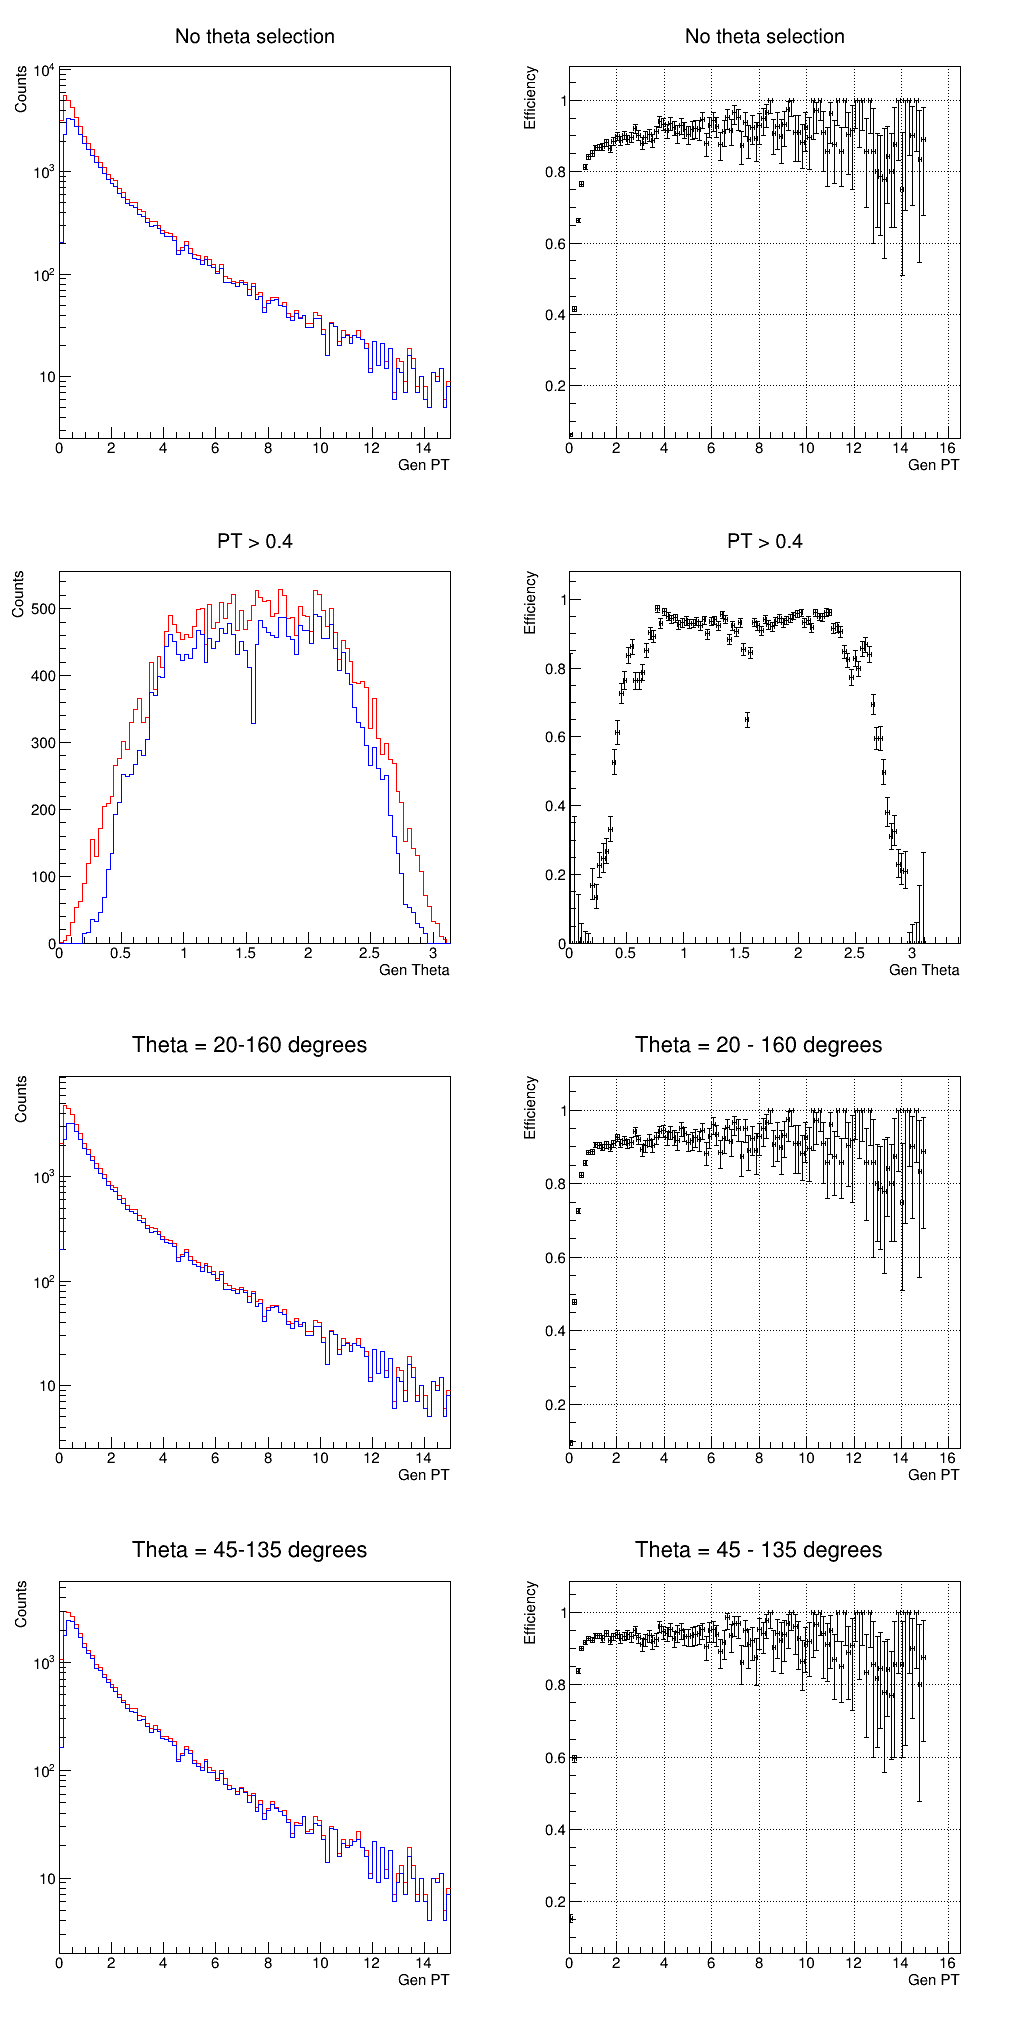

In [20]:
Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 2048)

Canvas.Divide(2, 4)

Canvas.cd(1).SetLogy()
HPionPTAll.SetLineColor(ROOT.kRed)
HPionPTAll.SetStats(0)
HPionPTAll.Draw()
HPionPTPass.SetLineColor(ROOT.kBlue)
HPionPTPass.Draw("same")

Canvas.cd(2).SetGridx()
Canvas.cd(2).SetGridy()
HPionPTEfficiency.Draw("ap")

Canvas.cd(3)
HPionThetaAll.SetLineColor(ROOT.kRed)
HPionThetaAll.SetStats(0)
HPionThetaAll.Draw()
HPionThetaPass.SetLineColor(ROOT.kBlue)
HPionThetaPass.Draw("same")

Canvas.cd(4)
HPionThetaEfficiency.Draw("ap")

Canvas.cd(5).SetLogy()
HPionPTInAll.SetLineColor(ROOT.kRed)
HPionPTInAll.SetStats(0)
HPionPTInAll.Draw()
HPionPTInPass.SetLineColor(ROOT.kBlue)
HPionPTInPass.Draw("same")

Canvas.cd(6).SetGridx()
Canvas.cd(6).SetGridy()
HPionPTInEfficiency.Draw("ap")

Canvas.cd(7).SetLogy()
HPionPTBBAll.SetLineColor(ROOT.kRed)
HPionPTBBAll.SetStats(0)
HPionPTBBAll.Draw()
HPionPTBBPass.SetLineColor(ROOT.kBlue)
HPionPTBBPass.Draw("same")

Canvas.cd(8).SetGridy()
Canvas.cd(8).SetGridx()
HPionPTBBEfficiency.Draw("ap")

Canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


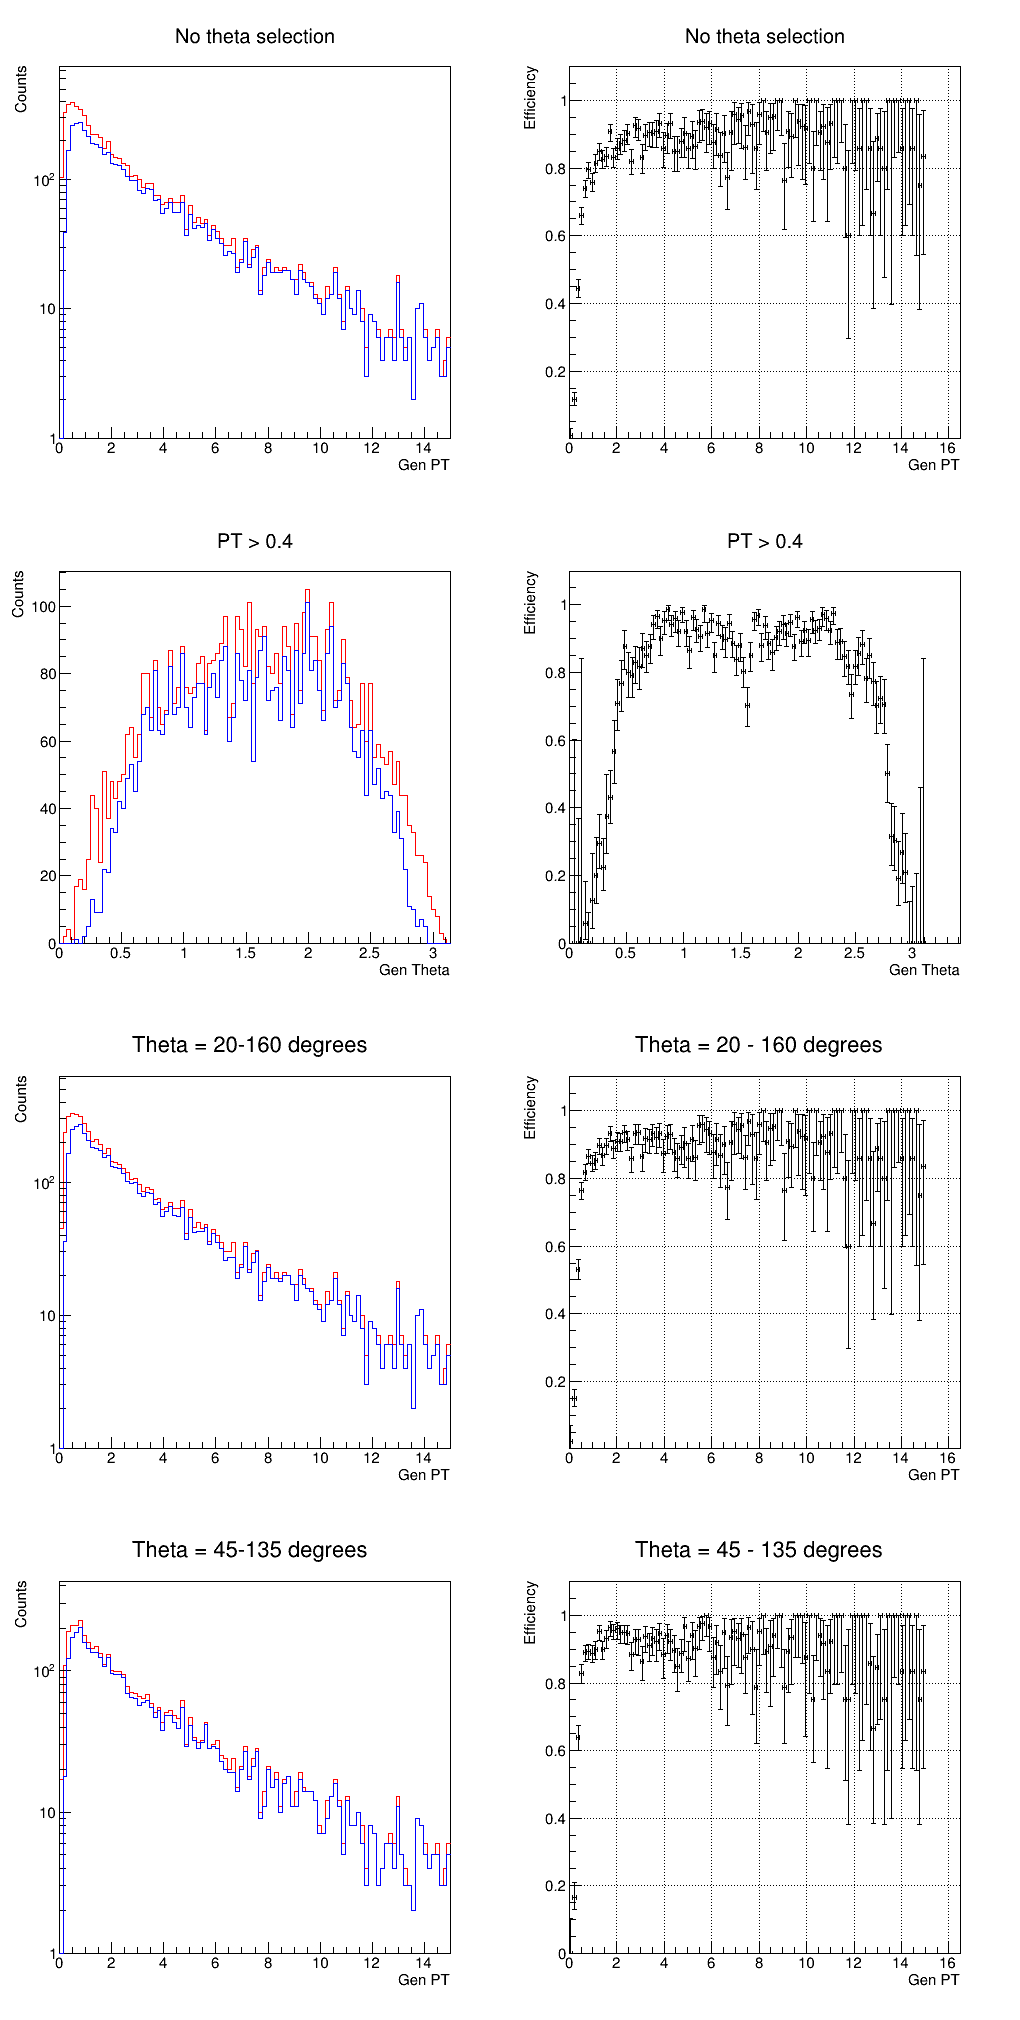

In [21]:
Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 2048)

Canvas.Divide(2, 4)

Canvas.cd(1).SetLogy()
HKaonPTAll.SetLineColor(ROOT.kRed)
HKaonPTAll.SetStats(0)
HKaonPTAll.Draw()
HKaonPTPass.SetLineColor(ROOT.kBlue)
HKaonPTPass.Draw("same")

Canvas.cd(2).SetGridx()
Canvas.cd(2).SetGridy()
HKaonPTEfficiency.Draw("ap")

Canvas.cd(3)
HKaonThetaAll.SetLineColor(ROOT.kRed)
HKaonThetaAll.SetStats(0)
HKaonThetaAll.Draw()
HKaonThetaPass.SetLineColor(ROOT.kBlue)
HKaonThetaPass.Draw("same")

Canvas.cd(4)
HKaonThetaEfficiency.Draw("ap")

Canvas.cd(5).SetLogy()
HKaonPTInAll.SetLineColor(ROOT.kRed)
HKaonPTInAll.SetStats(0)
HKaonPTInAll.Draw()
HKaonPTInPass.SetLineColor(ROOT.kBlue)
HKaonPTInPass.Draw("same")

Canvas.cd(6).SetGridx()
Canvas.cd(6).SetGridy()
HKaonPTInEfficiency.Draw("ap")

Canvas.cd(7).SetLogy()
HKaonPTBBAll.SetLineColor(ROOT.kRed)
HKaonPTBBAll.SetStats(0)
HKaonPTBBAll.Draw()
HKaonPTBBPass.SetLineColor(ROOT.kBlue)
HKaonPTBBPass.Draw("same")

Canvas.cd(8).SetGridy()
Canvas.cd(8).SetGridx()
HKaonPTBBEfficiency.Draw("ap")

Canvas.Draw()

In [21]:
# Now that we have something that kind of works, it's time to look into PID stuff.  Let's play with dedx first

In [25]:
HDEDXAll = ROOT.TH2D("HDEDXAll", "Everything;p;dE/dx", 100, 0, 2.5, 100, 0, 5)
HDEDXPion = ROOT.TH2D("HDEDXPion", "Matched with pions;p;dE/dx", 100, 0, 2.5, 100, 0, 5)
HDEDXKaon = ROOT.TH2D("HDEDXKaon", "Matched with kaons;p;dE/dx", 100, 0, 2.5, 100, 0, 5)

for iE in range(len(GenPion)):
    # Again get stuff out of the awkwardness to speed things up
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)
    DEDX = np.array(PID[iE].dedx)

    NReco = len(RecoPx)

    for iR in range(NReco):
        RecoPT = Magnitude(RecoPx[iR], RecoPy[iR], 0)
        RecoP = Magnitude(RecoPx[iR], RecoPy[iR], RecoPz[iR])
        RecoTheta = GetAngle(RecoPx[iR], RecoPy[iR], RecoPz[iR], 0, 0, 1)

        HDEDXAll.Fill(RecoP, DEDX[iR])

    NGen = len(GenPion[iE].px)
    GenPx = np.array(GenPion[iE].px)
    GenPy = np.array(GenPion[iE].py)
    GenPz = np.array(GenPion[iE].pz)
    
    for iG in range(NGen):
        GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
        GenP = Magnitude(GenPx[iG], GenPy[iG], GenPz[iG])
        GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)

        MatchedDEDX = 0
        if GenPionMatch[iE][iG] > 0:
            Index = int(GenPionMatch[iE][iG])

            MatchedDEDX = DEDX[Index]
            RecoPT = Magnitude(RecoPx[Index], RecoPy[Index], 0)
            RecoP = Magnitude(RecoPx[Index], RecoPy[Index], RecoPz[Index])
            RecoTheta = GetAngle(RecoPx[Index], RecoPy[Index], RecoPz[Index], 0, 0, 1)

            if GenPionAngle[iE][iG] < 0.01:
                HDEDXPion.Fill(RecoP, MatchedDEDX)

    NGen = len(GenKaon[iE].px)
    GenPx = np.array(GenKaon[iE].px)
    GenPy = np.array(GenKaon[iE].py)
    GenPz = np.array(GenKaon[iE].pz)
    
    for iG in range(NGen):
        GenPT = Magnitude(GenPx[iG], GenPy[iG], 0)
        GenP = Magnitude(GenPx[iG], GenPy[iG], GenPz[iG])
        GenTheta = GetAngle(GenPx[iG], GenPy[iG], GenPz[iG], 0, 0, 1)

        MatchedDEDX = 0
        if GenKaonMatch[iE][iG] > 0:
            Index = int(GenKaonMatch[iE][iG])

            MatchedDEDX = DEDX[Index]
            RecoPT = Magnitude(RecoPx[Index], RecoPy[Index], 0)
            RecoP = Magnitude(RecoPx[Index], RecoPy[Index], RecoPz[Index])
            RecoTheta = GetAngle(RecoPx[Index], RecoPy[Index], RecoPz[Index], 0, 0, 1)

            if GenKaonAngle[iE][iG] < 0.01:
                HDEDXKaon.Fill(RecoP, MatchedDEDX)


Warning in <TROOT::Append>: Replacing existing TH1: HDEDXAll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HDEDXPion (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HDEDXKaon (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


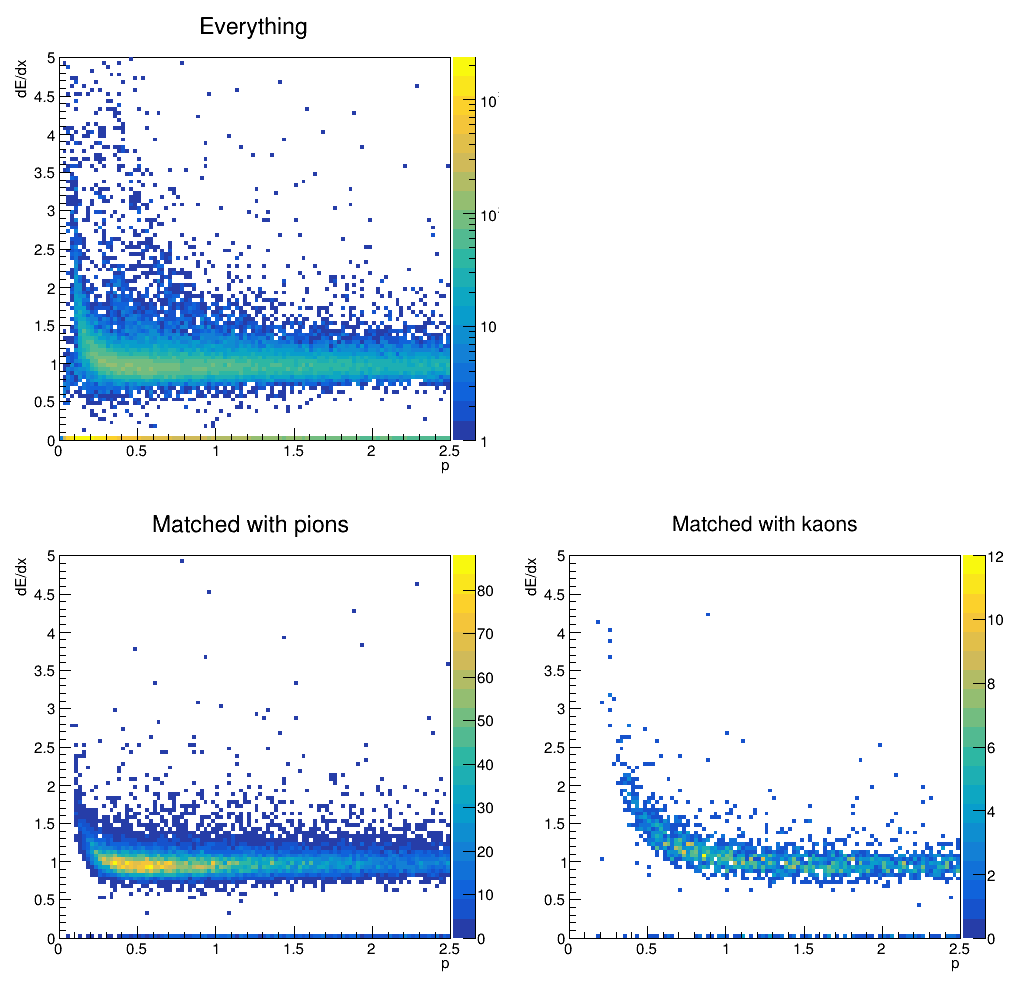

In [27]:
Canvas = ROOT.TCanvas("Canvas", "Canvas", 1024, 1024)

Canvas.Divide(2, 2)

Canvas.cd(1).SetLogz()
HDEDXAll.SetStats(0)
HDEDXAll.Draw("colz")

Canvas.cd(3)
HDEDXPion.SetStats(0)
HDEDXPion.Draw("colz")

Canvas.cd(4)
HDEDXKaon.SetStats(0)
HDEDXKaon.Draw("colz")

Canvas.Draw()

In [29]:
# Are there some PID discriminant there?
# Yes, these are the branches
# 'Haidc_electronTag',
# 'Haidc_heavyTag',
# 'Haidc_kaonTag',
# 'Haidc_pionTag',
# 'Haidc_protonTag',
# 'Haidc_selectionFlag